In [9]:
%matplotlib widget

from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import scipy
from typing import Callable
from mcmc_utils_and_plot import scatter_matrix, sub_sample_data, eval_func_on_grid, lognormpdf


# RAND_SEED = 0 # 1 diag, 0.9 off-diag
# RAND_SEED = 1 # identity cov
# RAND_SEED = 2 # .55 diag, .45 off-diag
RAND_SEED = 3 # 1 diag, 0.9 off-diag # pick this
# RAND_SEED = 4 # identity cov
# RAND_SEED = 5 # # .6 diag, .5 off-diag

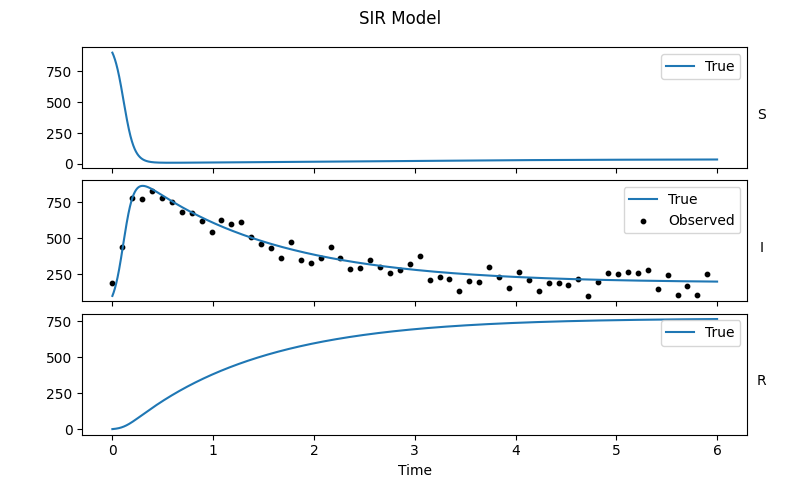

In [36]:
# Set up SIR problem
X_NAMES = ['S', 'I', 'R']
X_0 = np.array([900, 100, 0])
N = 1000
BETA_TRUE = 0.02
R_TRUE = 0.6
DELTA_TRUE = 0.15
NOISE_STD = 50


def f_p1(t, x, beta, r, delta):
    S, I, R = x
    return np.array([
        delta*N - delta * S - beta*I*S,
        beta*I*S - (r+delta)*I,
        r*I - delta*R])


def f_p2(t, x, gamma, kappa, r, delta):
    S, I, R = x
    return np.array([
        delta*N - delta * S - gamma*kappa*I*S,
        gamma*kappa*I*S - (r+delta)*I,
        r*I - delta*R])


@dataclass
class Solution:
    t: np.ndarray
    y: np.ndarray


@dataclass
class Observation:
    t: np.ndarray
    y: np.ndarray


T0 = 0
Tend = 6
Tsteps = 61
Tsteps_multiplier = 100  # increase the fidelity of the true solution
Teval = np.linspace(T0, Tend, Tsteps*Tsteps_multiplier)


def simulate_p1(params: np.ndarray) -> Solution:
    # problem 1: parameters beta, r, delta
    """Generate a solution for the states field for the given control params."""
    def f(t, x):
        return f_p1(t, x, params[0], params[1], params[2])

    def stp(t, y):
        if np.any(np.abs(y) > 2000):
            return 0
        return -1

    stp.terminal = True

    sol = scipy.integrate.solve_ivp(
        fun=f, t_span=(T0, Tend), y0=X_0, method='RK45', t_eval=Teval, events=stp)

    return Solution(sol.t, sol.y)  # y = 3(dims) x Tsteps(6100)


def simulate_p2(params: np.ndarray) -> Solution:
    # problem 2: parameters gamme, kappa, r, delta
    """Generate a solution for the states field for the given control params."""
    def f(t, x):
        return f_p2(t, x, params[0], params[1], params[2], params[3])

    def stp(t, y):
        if np.any(np.abs(y) > 2000):
            return 0
        return -1

    stp.terminal = True
    sol = scipy.integrate.solve_ivp(
        fun=f, t_span=(T0, Tend), y0=X_0, method='RK45', t_eval=Teval, events=stp)

    return Solution(sol.t, sol.y)  # y = 3(dims) x Tsteps(6100)


def sensor(solution: Solution) -> Observation:
    """Sensor model that extracts data from the solution."""
    # pick out every Tsteps_multiplier-th solution point
    idx_obs = np.arange(0, solution.t.shape[0], Tsteps_multiplier)
    return Observation(solution.t[idx_obs], solution.y[1, idx_obs])


def generate_data(true_beta=BETA_TRUE, true_r=R_TRUE, true_delta=DELTA_TRUE, noise_std=NOISE_STD):
    true_sim = simulate_p1([true_beta, true_r, true_delta])
    sensor_vals = sensor(true_sim)
    sensor_vals.y += noise_std * np.random.randn(sensor_vals.y.shape[0])
    return true_sim, sensor_vals


def plot_sir(fignum, t_true, x_true, t_sens, x_sens, x_names, title):
    plt.close(fignum)
    fig, axs = plt.subplots(x_true.shape[0], 1, sharex=True, num=fignum, figsize=(8, 5))
    fig.tight_layout(pad=3)
    fig.suptitle(title)
    for i, (ax, x_name) in enumerate(zip(axs, x_names)):
        ax.plot(t_true, x_true[i, :], label='True')
        if i == 1:
            ax.scatter(t_sens, x_sens, color='k', s=10, label='Observed')
        ax.set_ylabel(x_name, rotation=0, labelpad=10)
        ax.yaxis.set_label_position("right")
        ax.legend()
    axs[-1].set_xlabel('Time')
    fig.subplots_adjust(hspace=0.1)
    fig.savefig(f'figs/{title}.svg')
    plt.show()
    return fignum + 1


np.random.seed(RAND_SEED)
data_sim, data_sens = generate_data()
fignum = 1
fignum = plot_sir(fignum, data_sim.t, data_sim.y, data_sens.t,
                  data_sens.y, X_NAMES, "SIR Model")

In [11]:
# set up bayes learning problem
def multigauss_logpdf(obs: np.ndarray, data: np.ndarray, cov: np.ndarray) -> float:
    """
    Calculates the logpdf of observing the given data under a multivariate Gaussian distribution.
    Each observation MUST have its own data point as the mean and the same covariance matrix.

    Parameters:
    obs (numpy.ndarray): The observed data points, with shape (n_samples, n_features).
    data (numpy.ndarray): The mean of the multivariate Gaussian distribution, with shape (n_samples, n_features).
    cov (numpy.ndarray): The covariance matrix of the multivariate Gaussian distribution, with shape (n_features, n_features).

    Returns:
    float: The logpdf of observing the data under the multivariate Gaussian distribution.
    """
    dims = obs.shape[1]
    diff = obs - data
    const_term = dims * np.log(2 * np.pi) + np.log(np.linalg.det(cov))
    exponent_term = np.sum(np.dot(diff, np.linalg.inv(cov)) * diff, axis=1)
    return -0.5 * np.sum((const_term + exponent_term))


def log_prior(params: np.ndarray) -> float:
    # indep gaussian prior on k1, k2 with 0 mean and 1 variance
    # this returns an array for some reason, get the first element for float
    return lognormpdf(params.reshape(-1, 1), np.zeros(params.size), np.eye(params.size))[0]


def log_likelihood(sim_func: Callable, data: Observation, params: np.ndarray) -> float:
    # gaussian likelihood on the difference between the sensor data
    # and model output for the given parameters
    sim = sim_func(params)
    obs = sensor(sim)
    # this problem has only 1 dimension in data, so cant use y.shape[0]
    cov = NOISE_STD**2 * np.eye(1)
    # reshape here insteadof transpose cos y is 1 dimensional here
    return multigauss_logpdf(data.y.reshape(-1, 1), obs.y.reshape(-1, 1), cov)


def log_posterior(sim_func: Callable, params: np.ndarray, data: Observation) -> float:
    return log_prior(params) + log_likelihood(sim_func, data, params)

In [12]:
# Find starting point for MCMC

def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation.

    Return the MAP point and an approximation of the covariance

    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior

    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)

    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead')
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx


def logpost_p1(params): return log_posterior(simulate_p1, params, data_sens)
def logpost_p2(params): return log_posterior(simulate_p2, params, data_sens)


np.random.seed(RAND_SEED)
init_sample_p1 = np.zeros(3)
# init_sample_p1 = np.array([BETA_TRUE, R_TRUE, DELTA_TRUE])
map_p1, cov_approx_p1 = laplace_approx(np.array(init_sample_p1), logpost_p1)
# scale the covariance according to eq 16.6 in the notes
cov_approx_p1 = cov_approx_p1 / init_sample_p1.shape[0] * 2.4**2
print(f"Problem 1:\n- MAP: {map_p1}\n- Covariance:\n{cov_approx_p1}")
init_sample_p2 = np.zeros(4)
map_p2, cov_approx_p2 = laplace_approx(np.array(init_sample_p2), logpost_p2)
# scale the covariance according to eq 16.6 in the notes
cov_approx_p2 = cov_approx_p2 / init_sample_p2.shape[0] * 2.4**2
print(f"Problem 2:\n- MAP: {map_p2}\n- Covariance:\n{cov_approx_p2}")

Problem 1:
- MAP: [0.02008251 0.61444351 0.14098619]
- Covariance:
[[ 4.82564094e-06 -6.58406798e-06 -4.59524017e-06]
 [-6.58406798e-06  1.23289295e-03  6.73081629e-04]
 [-4.59524017e-06  6.73081629e-04  5.56126832e-04]]
Problem 2:
- MAP: [0.14170413 0.14170406 0.61444686 0.14098853]
- Covariance:
[[ 0.00076125 -0.00074788  0.00018916  0.00017149]
 [-0.00074788  0.00097256 -0.00019211 -0.00017223]
 [ 0.00018916 -0.00019211  0.00070551  0.00037287]
 [ 0.00017149 -0.00017223  0.00037287  0.00033792]]


In [13]:
# Set up MCMC
def prop_rw_cov_sampler(x: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """Sample from a random walk proposal with covariance `cov`."""
    # propose using cholesky decomposition https://juanitorduz.github.io/multivariate_normal/
    # inversion is different than cholesky
    # https://stats.stackexchange.com/questions/503058/relationship-between-cholesky-decomposition-and-matrix-inversion
    return x + np.dot(np.linalg.cholesky(cov), np.random.randn(x.shape[0]))
    # use the lognormpdf to get the pdf for this


class DelayedRejectionAdaptiveMetropolis:

    def __init__(self, target_logpdf, cov, adapt_time=100, sd=None, max_samples=10000, eps=1e-7, gamma=0.5):
        """The class constructor, parameters are documented below"""
        self.target_logpdf = target_logpdf  # callable (param) -> logpdf defining the logpdf
        self.cov_est = cov  # proposal covariance
        self.cov_init = cov  # initial covariance
        self.dims = cov.shape[0]  # number of parameters
        # self.cov_chol = np.linalg.cholesky(cov)  # sqrt of the covariance
        self.dim = cov.shape[0]  # number of parameters
        self.adapt_time = adapt_time  # time to start adapting
        # self.adapt_freq = adapt_freq  # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd  # scale for the covariance
        self.max_samples = max_samples  # maximum number of samples
        self.eps = eps  # nugget for ensuring positive definite
        self.gamma = gamma  # scale for the second proposal
        self.num_samples = 0  # number of samples generated
        self.samples = np.zeros((max_samples, self.dim))  # store the samples
        self.sample_mean = np.zeros((self.dim))  # store the sample mean
        self.target_logpdf_vals = np.zeros((max_samples))

    def a1(self, fx_x, fx_y):
        """ Acceptance probability given a symmetric proposal"""
        return min(np.exp(fx_y - fx_x), 1)

    def a2(self, fx_x, fx_y1, fx_y2, x, y1, y2, proposal1_func):
        """ Acceptance probability given a symmetric proposal"""
        q1_y2y1 = proposal1_func(y2, y1)
        q1_xy1 = proposal1_func(x, y1)
        a1_top = np.log(1-self.a1(fx_y2, fx_y1))
        a1_bot = np.log(1-self.a1(fx_x, fx_y1))
        check = fx_y2 - fx_x + q1_y2y1 - q1_xy1 + a1_top - a1_bot
        if check < 0:
            return np.exp(check)
        return 1.0

    def recur_mean(self, k, mean, x):
        return 1/(k+1) * x + k/(k+1) * mean

    def recur_cov_prop(self, k, cov_prop_k, sd, xi, mean_km1, mean_k, x_k):
        return (k-1)/k * cov_prop_k + sd/k * \
            (xi*np.eye(self.dims)
             + k*np.outer(mean_km1, mean_km1)
             - (k+1)*np.outer(mean_k, mean_k)
             + np.outer(x_k, x_k))

    def sample(self, initial_sample, num_samples):

        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"

        self.samples[0, :] = initial_sample
        self.sample_mean = self.recur_mean(0, self.sample_mean, initial_sample)
        self.target_logpdf_vals[0] = self.target_logpdf(initial_sample)

        num_accept = 1
        for ii in range(1, num_samples):

            # proposed1_sample = self.samples[ii-1, :] + \
            #     np.dot(self.cov_chol, np.random.randn(self.dim))
            if ii <= self.adapt_time:
                cov_use = self.cov_init
            else:
                cov_use = self.cov_est

            proposed1_sample = prop_rw_cov_sampler(self.samples[ii-1, :], cov_use)
            proposed1_target_logpdf = self.target_logpdf(proposed1_sample)
            # print(f'proposed1_sample: {proposed1_sample}')

            # compute accept-reject probability, using the fact that we have a symmetric proposal
            # a1 = np.exp(proposed1_target_logpdf - self.target_logpdf_vals[ii-1])
            # a1 = min(a1, 1)
            a1 = self.a1(self.target_logpdf_vals[ii-1], proposed1_target_logpdf)

            u = np.random.rand()
            if u < a1:  # accept
                self.samples[ii, :] = proposed1_sample
                self.target_logpdf_vals[ii] = proposed1_target_logpdf
                num_accept += 1
            else:  # rejected, try a second proposal with a scaled proposal
                # cov2 = self.cov * self.gamma
                # cov_chol2 = np.linalg.cholesky(cov2)
                # cov_inv = np.linalg.inv(self.cov)
                # proposed2_sample = self.samples[ii-1, :] + \
                #     np.dot(cov_chol2, np.random.randn(self.dim))
                proposed2_sample = prop_rw_cov_sampler(self.samples[ii-1, :], cov_use * self.gamma)
                # print(f'proposed2_sample: {proposed2_sample}')
                proposed2_target_logpdf = self.target_logpdf(proposed2_sample)

                # def propose1_logpdf(x, y):

                #     """ Probability of moving from x to y (in this case it is symmetric)."""
                #     delta = x - y
                #     return -0.5 * (delta.T @ cov_inv @ delta)
                def propose1_logpdf(x, y): return lognormpdf(y.reshape(self.dims, 1), x, cov_use)

                # compute accept-reject probability, using the fact that we have a symmetric proposal
                a2 = self.a2(self.target_logpdf_vals[ii-1], proposed1_target_logpdf,
                             proposed2_target_logpdf, self.samples[ii-1, :], proposed1_sample,
                             proposed2_sample, propose1_logpdf)
                u = np.random.rand()
                if u < a2:
                    self.samples[ii, :] = proposed2_sample
                    self.target_logpdf_vals[ii] = proposed2_target_logpdf
                    num_accept += 1
                else:
                    # print('Both proposals rejected')
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.target_logpdf_vals[ii] = self.target_logpdf_vals[ii-1]

            self.num_samples += 1
            mean_km1 = self.sample_mean
            self.sample_mean = self.recur_mean(ii, self.sample_mean, self.samples[ii, :])
            self.cov_est = self.recur_cov_prop(ii, self.cov_est, self.sd,
                                               self.eps, mean_km1, self.sample_mean, self.samples[ii, :])
            # adapt covariance if its time
            # if ii > self.adapt_time and ii % self.adapt_freq == 0:
            # THE NEXT TWO LINES ARE UNACCEPTABLE IN YOUR PROJECT
            # sample_cov = np.cov(self.samples[:self.num_samples, :], rowvar=False)
            # self.cov_prop = self.sd * (sample_cov + self.eps * np.eye(self.dim))
            # self.cov_chol = np.linalg.cholesky(self.cov_prop)

            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {num_accept / self.num_samples}")
        # print(f'cov: {self.cov_prop}')
        return self.samples, num_accept / float(self.num_samples - 1)

In [40]:
# run MCMC for problem 1
NUM_SAMPLES = 20000
np.random.seed(RAND_SEED)
dram_p1 = DelayedRejectionAdaptiveMetropolis(
    logpost_p1, cov_approx_p1, max_samples=NUM_SAMPLES, gamma=0.5, sd=6)
s_dram_p1, ar_dram_p1 = dram_p1.sample(map_p1, NUM_SAMPLES)
print(f'Problem 1:\n- Acceptance ratio: {ar_dram_p1}\n- Sample mean: {np.mean(s_dram_p1, axis=0)}')

/tmp/ipykernel_247641/1867603847.py:43: RuntimeWarning: divide by zero encountered in log
  a1_top = np.log(1-self.a1(fx_y2, fx_y1))


Finished sample 1000, acceptance ratio = 0.319
Finished sample 2000, acceptance ratio = 0.325
Finished sample 3000, acceptance ratio = 0.2996666666666667
Finished sample 4000, acceptance ratio = 0.30225
Finished sample 5000, acceptance ratio = 0.3014
Finished sample 6000, acceptance ratio = 0.303
Finished sample 7000, acceptance ratio = 0.30228571428571427
Finished sample 8000, acceptance ratio = 0.302375
Finished sample 9000, acceptance ratio = 0.30233333333333334
Finished sample 10000, acceptance ratio = 0.3027
Finished sample 11000, acceptance ratio = 0.306
Finished sample 12000, acceptance ratio = 0.30533333333333335
Finished sample 13000, acceptance ratio = 0.3056153846153846
Finished sample 14000, acceptance ratio = 0.30614285714285716
Finished sample 15000, acceptance ratio = 0.3065333333333333
Finished sample 16000, acceptance ratio = 0.306375
Finished sample 17000, acceptance ratio = 0.305
Finished sample 18000, acceptance ratio = 0.30483333333333335
Finished sample 19000, acc

In [45]:
# run MCMC for problem 2
NUM_SAMPLES = 20000
np.random.seed(RAND_SEED)
dram_p2 = DelayedRejectionAdaptiveMetropolis(
    logpost_p2, cov_approx_p2, max_samples=NUM_SAMPLES, gamma=0.5, sd=2)
s_dram_p2, ar_dram_p2 = dram_p2.sample(map_p2, NUM_SAMPLES)
print(f'Problem 2:\n- Acceptance ratio: {ar_dram_p2}\n- Sample mean: {np.mean(s_dram_p2, axis=0)}')

/tmp/ipykernel_247641/1867603847.py:43: RuntimeWarning: divide by zero encountered in log
  a1_top = np.log(1-self.a1(fx_y2, fx_y1))
/tmp/ipykernel_247641/1867603847.py:37: RuntimeWarning: overflow encountered in exp
  return min(np.exp(fx_y - fx_x), 1)


Finished sample 1000, acceptance ratio = 0.221
Finished sample 2000, acceptance ratio = 0.155
Finished sample 3000, acceptance ratio = 0.12633333333333333
Finished sample 4000, acceptance ratio = 0.10775
Finished sample 5000, acceptance ratio = 0.094
Finished sample 6000, acceptance ratio = 0.08766666666666667
Finished sample 7000, acceptance ratio = 0.08042857142857143
Finished sample 8000, acceptance ratio = 0.073375
Finished sample 9000, acceptance ratio = 0.06855555555555555
Finished sample 10000, acceptance ratio = 0.0628
Finished sample 11000, acceptance ratio = 0.06027272727272727
Finished sample 12000, acceptance ratio = 0.05775
Finished sample 13000, acceptance ratio = 0.055
Finished sample 14000, acceptance ratio = 0.0525
Finished sample 15000, acceptance ratio = 0.05053333333333333
Finished sample 16000, acceptance ratio = 0.0481875
Finished sample 17000, acceptance ratio = 0.04717647058823529
Finished sample 18000, acceptance ratio = 0.04583333333333333
Finished sample 1900

Sample at which autocorrelation hits 0:
- 2.B Problem 1: 17
- 2.B Problem 2: 173


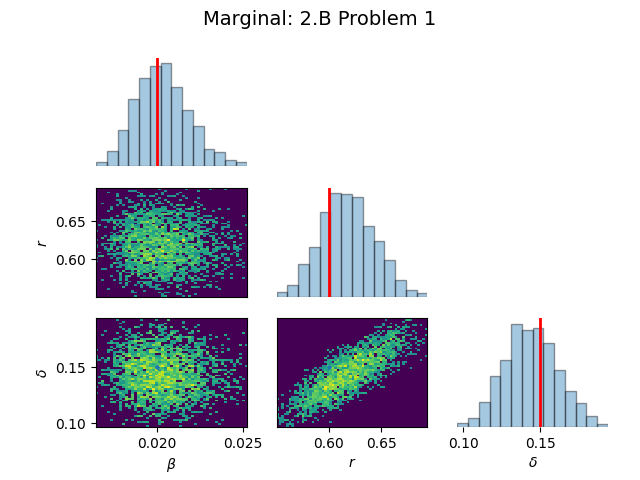

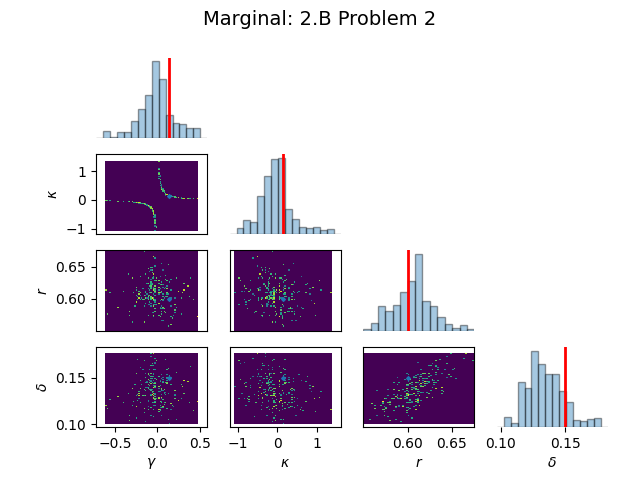

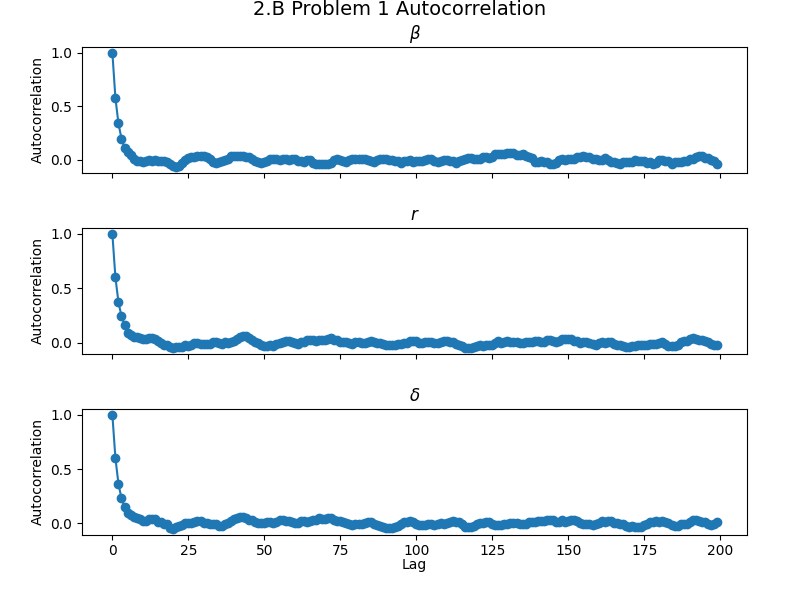

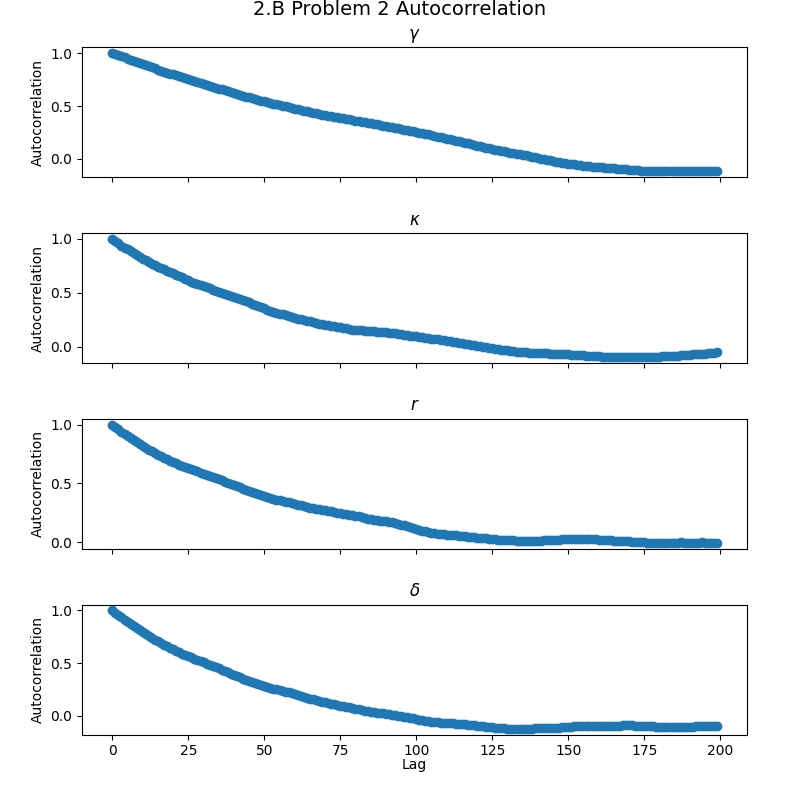

Integrated autocorrelation values:
- 2.B Problem 1: [2.60974271 4.61043376 6.36887657]
- 2.B Problem 2: [115.2713023   74.78636396  94.1191734   50.05099136]
Acceptance ratio:
- 2.B Problem 1: 30%
- 2.B Problem 2: 4%


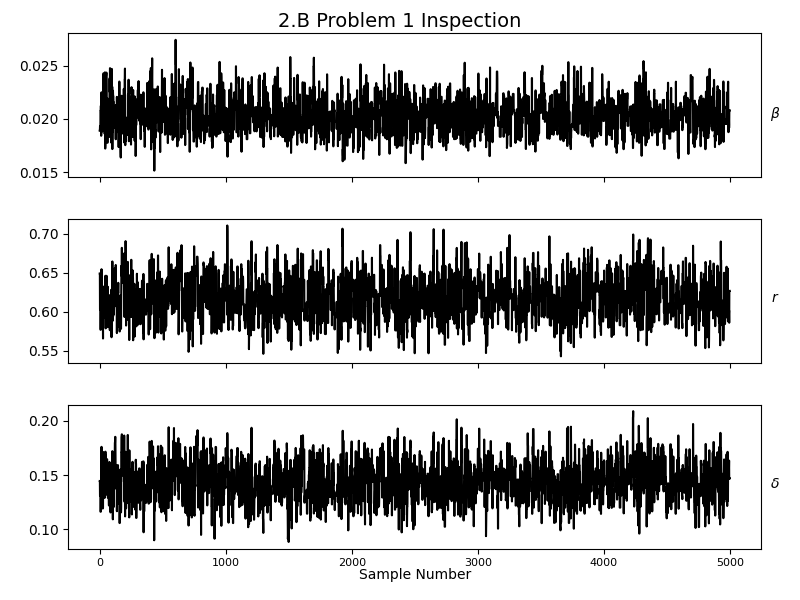

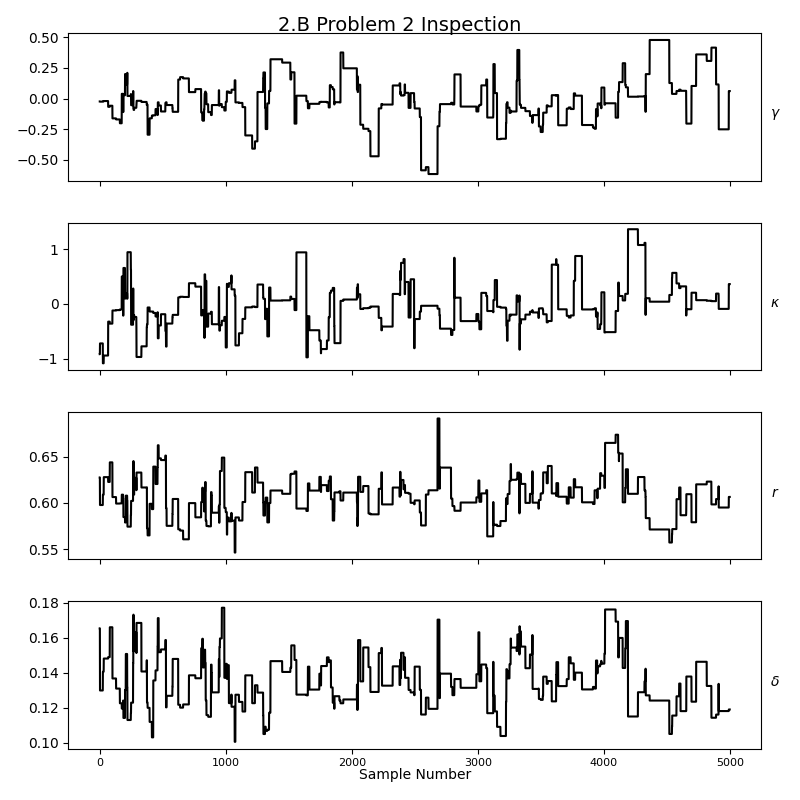

In [46]:
# Analyze and plot results
def autocorr_fast(samples: np.ndarray, maxlag: int = 100, step: int = 1):
    """Compute the correlation of a set of samples.

    Args:
        samples: (N, d)
        maxlag: maximum distance to compute the correlation for
        step: step between distances from 0 to maxlag for which to compute the correlations
    """

    # Get the shapes
    ndim = samples.shape[1]

    # Compute the mean
    mean = np.mean(samples, axis=0)

    denominator = np.sum((samples - mean)**2, axis=0)

    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    autos[0, :] = denominator * np.ones((ndim))  # lag 0 has max autocorrelation of 1
    for zz, lag in enumerate(lags[1:]):  # skip the lag of 0
        autos[zz+1, :] = np.sum((samples[:-lag, :] - mean) * (samples[lag:, :] - mean), axis=0)
    autos = autos/denominator
    return lags, autos


def plot_marginal(fignum, sampless, titles, labels, truths):
    for samples, title, label, truth in zip(sampless, titles, labels, truths):
        plt.close(fignum)
        fig, _, _ = scatter_matrix(fignum, [samples], labels=label, hist_plot=True, gamma=0.2,
                                   nbins=70, title=f'Marginal: {title}', specials={"vals": truth})
        plt.show()
        fig.savefig(f'figs/{title}_marginal.svg')
        fignum += 1
    return fignum


def plot_autocorrelation(fignum, lagss, autolags, titles, labels):
    for lags, autolag, title, label in zip(lagss, autolags, titles, labels):
        n_plots = len(label)
        plt.close(fignum)
        fig, axs = plt.subplots(n_plots, 1, figsize=(8, n_plots*2), num=fignum, sharex=True)
        fig.tight_layout(pad=3)
        fig.suptitle(f'{title} Autocorrelation', fontsize=14, y=1)
        for i, lab in enumerate(label):
            ax = axs[i]
            ax.plot(lags, autolag[:, i], '-o')
            ax.set_ylabel('Autocorrelation')
            ax.set_title(f'{lab}')
        axs[-1].set_xlabel('Lag', labelpad=0)
        plt.show()
        fig.savefig(f'figs/{title}_autocorrelation.svg')
        fignum += 1
    return fignum


def plot_inspection(fignum, sampless, titles, labels):
    for samples, title, label in zip(sampless, titles, labels):
        n_plts = len(label)
        plt.close(fignum)
        fig, axs = plt.subplots(n_plts, 1, figsize=(8, n_plts*2), num=fignum, sharex=True)
        fig.tight_layout(pad=2)
        fig.suptitle(f'{title} Inspection', fontsize=14, y=0.98)
        for i, lab in enumerate(label):
            ax = axs[i]
            ax.plot(samples[:, i], '-k')
            ax.set_ylabel(lab, rotation=0, labelpad=10)
            ax.yaxis.set_label_position("right")
        axs[-1].set_xlabel('Sample Number', labelpad=0)
        plt.xticks(fontsize=8)
        plt.show()
        fig.savefig(f'figs/{title}_inspection.svg')
        fignum += 1
    return fignum


def plot_predictive(fignum, sim_func, params, data_sim, data_sens, x_names, title):
    plt.close(fignum)
    fig, axs = plt.subplots(data_sim.y.shape[0], 1, sharex=True, num=fignum, figsize=(8, 5))
    fig.tight_layout(pad=3)
    fig.suptitle(f'{title} Predictive', fontsize=14)
    predictive_data = []
    for param in params:
        predictive_data.append(sim_func(param))
    for i, (ax, x_name) in enumerate(zip(axs, x_names)):
        ax.plot(data_sim.t, data_sim.y[i, :], label='True')
        if i == 1:
            ax.scatter(data_sens.t, data_sens.y, color='k', s=10, label='Data')
        for pred_data in predictive_data:
            ax.plot(pred_data.t, pred_data.y[i, :], color='gray', alpha=0.5)
        ax.set_ylabel(x_name, rotation=0, labelpad=10)
        ax.yaxis.set_label_position("right")
        ax.set_ylim([0, 1000])
        ax.legend()
    axs[-1].set_xlabel('Time')
    fig.subplots_adjust(hspace=0.1)
    fig.savefig(f'figs/{title}_predictive.svg')
    plt.show()
    return fignum + 1


titles = ["2.B Problem 1", "2.B Problem 2"]
labels = [[r'$\beta$', r'$r$', r'$\delta$'], [r'$\gamma$', r'$\kappa$', r'$r$', r'$\delta$']]
truths = [np.array([BETA_TRUE, R_TRUE, DELTA_TRUE]), np.array([0.14, 0.14, R_TRUE, DELTA_TRUE])]

BETA_TRUE = 0.02
R_TRUE = 0.6
DELTA_TRUE = 0.15
# samples with burn in (samples, frac_burn, frac_use)
sampless = [sub_sample_data(s_dram_p1, frac_burn=0.5, frac_use=0.5),
            sub_sample_data(s_dram_p2, frac_burn=0.5, frac_use=0.5)]

ars = [ar_dram_p1, ar_dram_p2]

MAXLAG = 1000
STEP = 1  # step 1 so can reuse the data for IAC

goodlag = 0
print(f'Sample at which autocorrelation hits 0:')
for samples, title in zip(sampless, titles):
    _, autolag = autocorr_fast(samples, maxlag=MAXLAG, step=STEP)
    # get the id of first autocorrelatation lag that hits 0, and get the max of the ids
    zeroautocorr = np.argmin(np.where(autolag < 0, 0, autolag), axis=0)
    goodlag = max(np.max(zeroautocorr), goodlag)
    print(f"- {title}: {goodlag}")


goodlag = int(np.ceil(goodlag/100))*100  # round up to nearest 100
lags_auto = []
autolags = []
for samples in sampless:
    lags, autolag = autocorr_fast(samples, maxlag=goodlag, step=STEP)
    lags_auto.append(lags)
    autolags.append(autolag)

iacs = []
for autolag in autolags:
    # start from lag 1
    iacs.append(1 + 2*np.sum(autolag[1:, :], axis=0))
    # iacs.append(1 + 2*np.cumsum(autolag[1:, :], axis=0))

# 5.a Plots of 1D and 2D marginals
fignum = plot_marginal(fignum, sampless, titles, labels, truths)

# 5.b Autocorrelation plots
fignum = plot_autocorrelation(fignum, lags_auto, autolags, titles, labels)

# 5.c Integrated autocorrelation values
print(f"Integrated autocorrelation values:")
for iac, title in zip(iacs, titles):
    print(f"- {title}: {iac}")

# 5.d Acceptance ratio
print(f"Acceptance ratio:")
for ar, title in zip(ars, titles):
    print(f"- {title}: {ar*100:.0f}%")

# 5.e Visual inspection of mixing
fignum = plot_inspection(fignum, sampless, titles, labels)

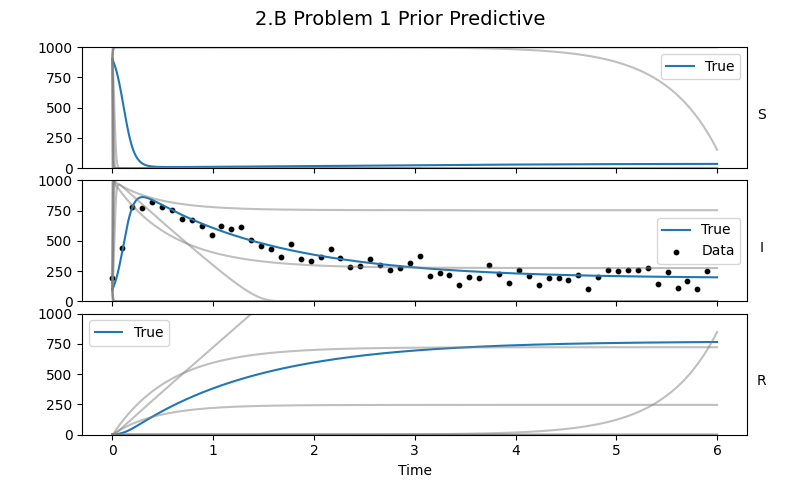

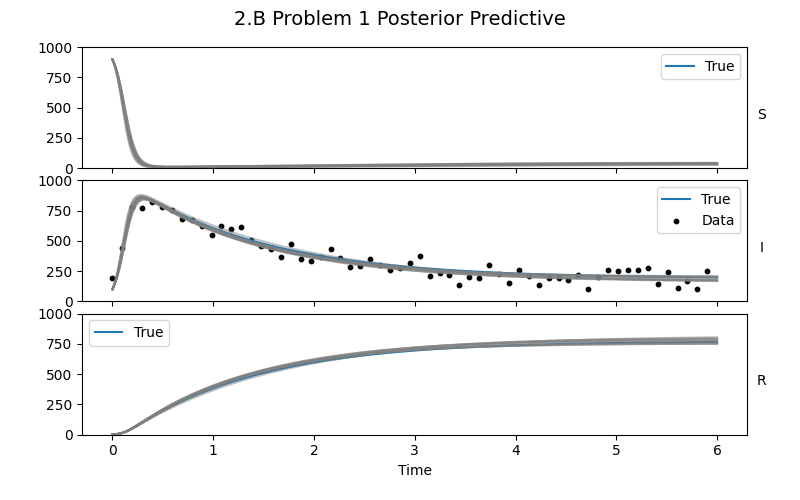

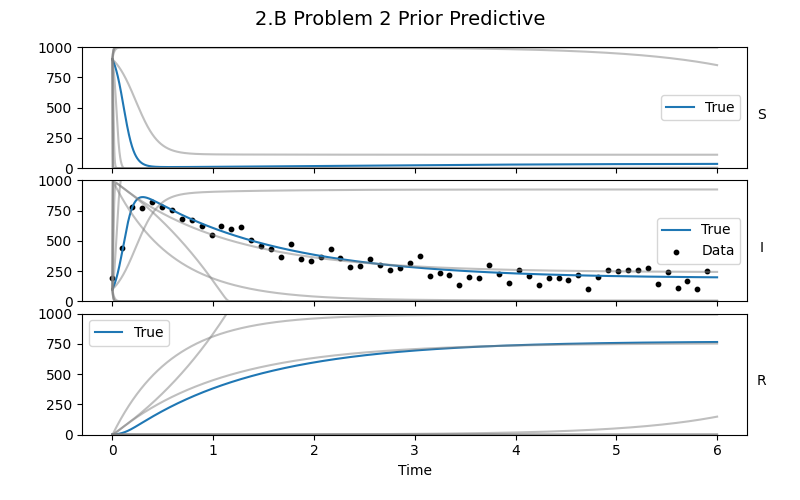

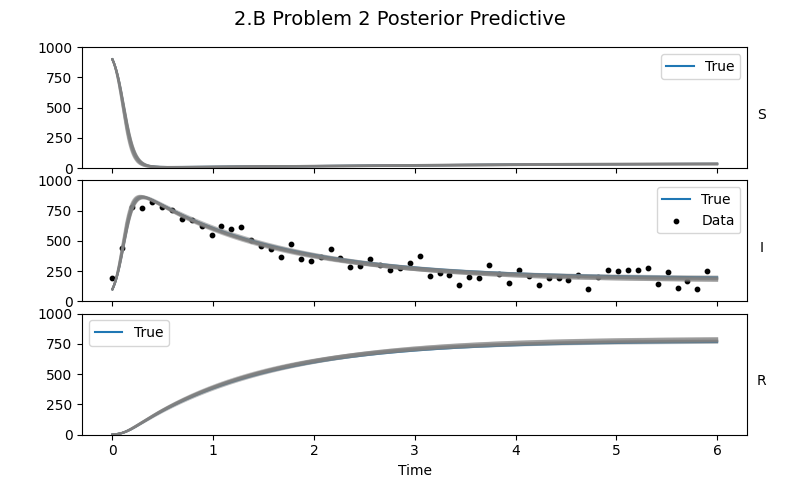

In [47]:
samples_post = [sub_sample_data(s_dram_p1, frac_burn=0.5, frac_use=0.001),
                sub_sample_data(s_dram_p2, frac_burn=0.5, frac_use=0.001)]

samples_prior = [np.random.randn(10, 3),
                 np.random.randn(10, 4)]

fignum = plot_predictive(
    fignum, simulate_p1, samples_prior[0], data_sim, data_sens, X_NAMES, "2.B Problem 1 Prior")
fignum = plot_predictive(
    fignum, simulate_p1, samples_post[0], data_sim, data_sens, X_NAMES, "2.B Problem 1 Posterior")
fignum = plot_predictive(
    fignum, simulate_p2, samples_prior[1], data_sim, data_sens, X_NAMES, "2.B Problem 2 Prior")
fignum = plot_predictive(
    fignum, simulate_p2, samples_post[1], data_sim, data_sens, X_NAMES, "2.B Problem 2 Posterior")